In [1]:
from PIL import Image
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import os
import random
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms as T
import time
import copy
import pydicom
import matplotlib.pyplot as plt
from skimage.draw import polygon
import plistlib
import pandas
import cv2
import skimage.transform as skt
import sklearn.cluster

In [2]:
#dataset location:
root='INbreast Release 1.0/'
#gpu choice:
device='cuda:0'
#enable/disable mixed precision:
use_amp=False
scaler=torch.cuda.amp.GradScaler(enabled=use_amp)
#Folder for trained models:
TrainedPath='Trained/'
#Name of DNN:
NetName='FasterRCNNINbreastMasses'

# Read data

### Read region of interest

In [3]:
def load_inbreast_mask(mask_path, imshape=(4084, 3328)):
    """
    This function loads a osirix xml region as a binary numpy array for INBREAST
    dataset
    mask_path : Path to the xml file
    imshape : The shape of the image as an array e.g. [4084, 3328]
    return: numpy array where positions in the roi are assigned a value of 1.
    Source: https://gist.github.com/jendelel/3a8e768a8eb9345d49f2a82d02946122
    My changes: changed to observe only masses.
    """

    def load_point(point_string):
        x, y = tuple([float(num) for num in point_string.strip('()').split(',')])
        return y, x
    #define matrix of zeros:
    mask = np.zeros(imshape)
    #draw mask:
    with open(mask_path, 'rb') as mask_file:
        plist_dict = plistlib.load(mask_file, fmt=plistlib.FMT_XML)['Images'][0]
        #number of regios of interest/objects:
        numRois = plist_dict['NumberOfROIs']
        rois = plist_dict['ROIs']
        assert len(rois) == numRois
        #draw each object:
        for roi in rois:
            #number of points in the object:
            numPoints = roi['NumberOfPoints']
            #coordinates:
            points = roi['Point_px']
            #class of the object:
            name = roi['Name']
            #ignore if object is not a mass:
            if (name == 'Mass'):
                #draw object:
                assert numPoints == len(points)
                points = [load_point(point) for point in points]
                if len(points) <= 2:
                    for point in points:
                        mask[int(point[0]), int(point[1])] = 1
                else:
                    x, y = zip(*points)
                    x, y = np.array(x), np.array(y)
                    poly_x, poly_y = polygon(x, y, shape=imshape)
                    mask[poly_x, poly_y] = 1
    return mask

### Select images with masses

In [4]:
#read dataset information file:
itens=pandas.read_excel(root+'INbreast.xls')

In [5]:
itens

Patient ID Patient age Laterality View  Acquisition date   File Name  ACR  \
0      removed     removed          R   CC          201001.0  22678622.0    4   
1      removed     removed          L   CC          201001.0  22678646.0    4   
2      removed     removed          R  MLO          201001.0  22678670.0    4   
3      removed     removed          L  MLO          201001.0  22678694.0    4   
4      removed     removed          R   CC          201001.0  22614074.0    2   
..         ...         ...        ...  ...               ...         ...  ...   
407    removed     removed          R  MLO          200802.0  24055752.0    4   
408    removed     removed          L   CC          200802.0  24055779.0    4   
409    removed     removed          R   CC          200802.0  24055806.0    4   
410        NaN         NaN        NaN  NaN               NaN         NaN  NaN   
411        NaN         NaN        NaN  NaN               NaN         NaN   28   

    Bi-Rads Mass Micros Distortion Asymmetry Findings Notes (in Portuguese)  \
0         1  NaN    NaN        NaN       NaN                         normal   
1         3    X    NaN        NaN       NaN                         nódulo   
2         1  NaN    NaN        NaN       NaN                         normal   
3         3    X    NaN        NaN       NaN                         nódulo   
4         5    X      X        NaN       NaN            nódulo QSE + micros   
..      ...  ...    ...        ...       ...                            ...   
407       2  NaN      X        NaN       NaN                         micros   
408       2  NaN      X        NaN       NaN                         micros   
409       2  NaN      X        NaN       NaN                         micros   
410     NaN  NaN    NaN        NaN       NaN                            NaN   
411      49  108    308          3        14                            NaN   

    Other Notes Lesion Annotation Status Pectoral Muscle Annotation  \
0           NaN   No annotation (Normal)                        NaN   
1           NaN                      NaN                        NaN   
2           NaN   No annotation (Normal)                        NaN   
3           NaN                      NaN                        NaN   
4           NaN                      NaN                        NaN   
..          ...                      ...                        ...   
407         NaN                      NaN                        NaN   
408         NaN                      NaN                        NaN   
409         NaN                      NaN                        NaN   
410         NaN                      NaN                        NaN   
411         NaN                      NaN                        NaN   

    Other Annotations  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
..                ...  
407               NaN  
408               NaN  
409               NaN  
410               NaN  
411               NaN  

[412 rows x 17 columns]

In [6]:
#Select images classified as "Mass":
images=[]
for i,item in enumerate(itens['Mass'],0):
    if (itens['Mass'][i] == 'X'):
        images.append(str(int(itens['File Name'][i])))

In [7]:
#remove images without masses masks:
tmp=[]
for image in images:
    if (image in ['22614097','22614150']):
        continue
    tmp.append(image)
images=tmp

In [8]:
#check total number of images with masses:
len(images)

106

### Transform masks in bounding boxes

In [9]:
def bb_maker(mass_mask):
    #creates bounding box coordinates from a mask
    #mass_mask: mask (np array, image)
    
    result=[]
    height, width = mass_mask.shape
    mask = mass_mask.copy()
    #find contours of each mass:
    cnts, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL,
                               cv2.CHAIN_APPROX_SIMPLE)
    #iterate over objects:
    for cnt in cnts:
        #create a bbox around the contours:
        x, y, w, h = cv2.boundingRect(cnt)
        #define box center:
        x = x+w//2 -1
        y= y+h//2 -1
        #find box extremes:
        x0=max(0,x-w//2)
        x1=min(width,x+w//2)
        y0=max(0,y-h//2)
        y1=min(height,y+h//2)
        #Check if shape is adequate and save bounding box to results:
        if ((x1-x0)>0 and (y1-y0)>0):
            result.append([x0,y0,x1,y1])
            
    if (len(result)==0):
        #points out a problem: no object in image
        return None
            
    return result


### Load function

In [10]:
def crop(img, mask):
    #remove borders of an image, leaving only the breast region
    #Crops the mask accordingly
    #img: image
    #mask: image mask
    
    #applies gaussian blur:
    blur = cv2.GaussianBlur(img,(5,5),0)
    #applies Otsu's thresholding method:
    _, breast_mask = cv2.threshold(blur,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    #find contours:
    cnts, _ = cv2.findContours(breast_mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)
    #returns cropped image and mask:
    return img[y:y+h, x:x+w], mask[y:y+h, x:x+w]

def ImageLoader (name,resize=False,size=(1024,1024)):
    #returns the image (numpy array) and mask
    #resize:resizes the image and mask
    #size: new size, if resize==True
    #name: image index
    
    #gets the complete filename for the image:
    for item in os.listdir(root+'AllDICOMs/'):
        if(name in item):
            imgFile=item
            break
        
    #gets complete filename for the mask:
    for item in os.listdir(root+'AllXML/'):
        if(name in item):
            xmlFile=item
            break     
    
    #load image:
    image=pydicom.dcmread(root+'AllDICOMs/'+imgFile).pixel_array
    
    #load mask:   
    mask=load_inbreast_mask(root+'AllXML/'+xmlFile,image.shape)
    
    #crop borders:
    image,mask=crop(image,mask)
    
    #resize (nearest neighbor interpolation):
    if(resize):
        image=cv2.resize(image, dsize=size, interpolation=cv2.INTER_NEAREST)
        mask=cv2.resize(mask, dsize=size, interpolation=cv2.INTER_NEAREST)
    
    return image,mask

In [11]:
def ToTorch (image):
    #Normalize image between 0 and 1, create 3 channels
    #and transforms into pytorch tensor.
    #image: image, np array
    
    #normalize:
    image=image/np.max(image)
    
    #to pytorch:
    image=torch.from_numpy(image.astype('float32'))
    
    #to 3 channels:
    image=[image,image,image]
    image=torch.stack(image)
    
    return image

### Visual analysis of the bounding boxes (ground truth)

Let's analyze the dataset image, masks and our created bounding boxes.

image name: 22678646


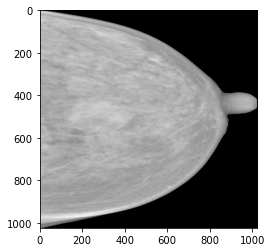

superposition of mask and bounding box:


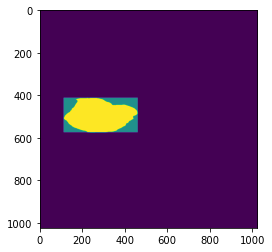

image name: 22678694


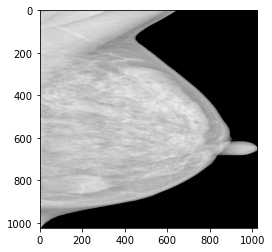

superposition of mask and bounding box:


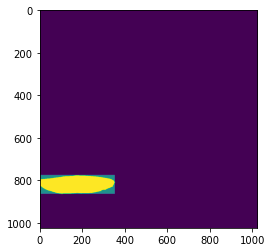

image name: 22614074


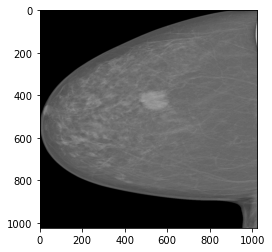

superposition of mask and bounding box:


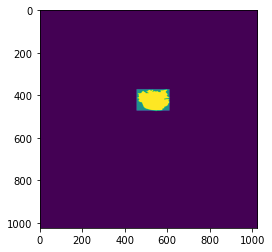

image name: 22614127


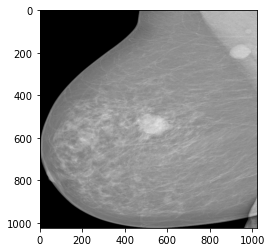

superposition of mask and bounding box:


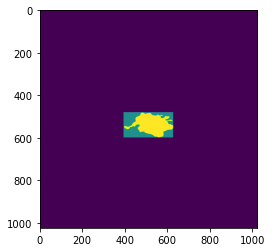

image name: 50997461


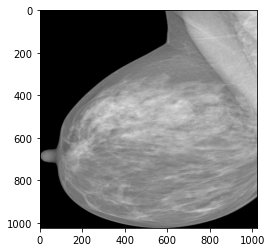

superposition of mask and bounding box:


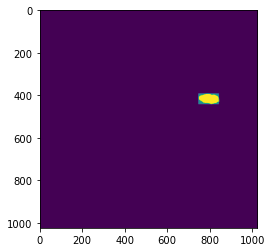

In [13]:
def plot (image,mask):
    #print images, masks and bounding boxes for the entire datset
    #with cropping and resizing.
    #image: images, np array
    #mask: mask, np array
    
    #create bounding boxes:
    bb=bb_maker(mask)
    
    #print image:
    plt.imshow(image, cmap=plt.cm.gray)
    plt.show()
    
    #draw bounding boxes in a matrix:
    bbview=np.zeros(mask.shape)
    for b in bb:
        bbview[int(b[1]):int(b[3]),int(b[0]):int(b[2])]=1
    
    #print the superposition of masks and bounding boxes:
    print('superposition of mask and bounding box:')
    plt.imshow(bbview*255+mask*255)
    plt.show()
    
#iterate over the 5 images in the dataset:
for i,name in enumerate(images,0):
    print('image name:', name)
    x,y=ImageLoader(name,resize=True)
    plot(x,y)
    if(i==4):
        break
    
    

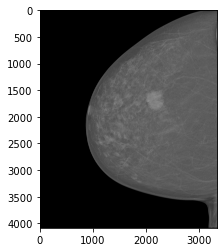

In [13]:
#observe example of original image (without cropping or resizing):

#gets the complete filename for the image:
for item in os.listdir(root+'AllDICOMs/'):
    if('22614074' in item):
        imgFile=item
        break
        
#load image:
image=pydicom.dcmread(root+'AllDICOMs/'+imgFile).pixel_array
plt.imshow(image, cmap=plt.cm.gray)
plt.show()


# Split dataset for hold-out validation and test

The dataset has 106 images showing breasts with masses. We will split the database in 3 parts, for training, validation and test. We will not divide according to the patients, since patient IDs are not available in the database.

We will use 70% of the images for training, 10% for hold-out validation (allowing early-stopping) and 20% for testing.

In [14]:
#slpit the list of images:
trainImages=images[:int(0.7*len(images))]
validationImages=images[int(0.7*len(images)):int(0.8*len(images))]
testImages=images[int(0.8*len(images)):]

In [15]:
#confirm if the 106 images were loaded:
print(len(trainImages)+len(testImages)+len(validationImages))

106


In [16]:
#save the lists:
torch.save(trainImages,'trainSplit.pt')
torch.save(testImages,'testSplit.pt')
torch.save(validationImages,'validationSplit.pt')

# Define data augmentation

Rotation, translation and flipping shall be applied both to images and masks, to augment the dataset, which is small in the context of deep learning databases.

In [17]:
def flip (images,masks):
    #randomly flips (horizontal) images and masks
    #images: list of images 
    #masks: list of corresponding masks
    
    #iterate over images and masks:
    for i,item in enumerate(images,0):
        #50% chance of flipping:
        n=random.randint(1,10)
        if(n>5):
            #flip:
            images[i]=np.fliplr(images[i])
            masks[i]=np.fliplr(masks[i])
            
def rotate (images,masks):
    #randomly rotates images and masks
    #images: list of images 
    #masks: list of corresponding masks
    
    #iterate over images and masks:
    for i,item in enumerate(images,0):
        tx,ty=images[i].copy(),masks[i].copy()
        #generate and apply random rotations (25 degrees limit): 
        ang=random.randrange(-25,25,1)
        tx=skt.rotate(tx,angle=float(ang),mode='constant')
        ty=skt.rotate(ty,angle=float(ang),mode='constant')
        #check if the mass is still inside the image 
        #and is not touching borders:
        temp_bb=bb_maker(ty)
        if(temp_bb is not None 
           and 0 not in temp_bb 
           and image.shape[0] not in temp_bb):
            #augment only if it is:
            images[i],masks[i]=tx,ty  
                
def translate (images,masks):
    #randomly translates images and masks
    #images: list of images 
    #masks: list of corresponding masks
    
    #iterate over images and masks:
    for i,item in enumerate(images,0):
        tx,ty=images[i].copy(),masks[i].copy()
        #define translation limits:
        heightLimit=int(min([0.15*tx.shape[0],bb_maker(ty)[0][1],
                            tx.shape[0]-bb_maker(ty)[0][3]]))
        legnthLimit=int(min([0.15*tx.shape[1],bb_maker(ty)[0][0],
                            tx.shape[1]-bb_maker(ty)[0][2]]))
        #generate and apply random rotations:
        if(legnthLimit!=0):
            h=random.randrange(-legnthLimit,legnthLimit,1)
        if(legnthLimit==0):
            h=0
        if(heightLimit!=0):
            v=random.randrange(-heightLimit,heightLimit,1)
        if(heightLimit==0):
            v=0
        transform = skt.AffineTransform(translation=(h,v))
        tx=skt.warp(tx,transform,mode='constant')
        ty=skt.warp(ty,transform,mode='constant')
        images[i],masks[i]=tx,ty     

def Augment (images,masks,n):
    #Generates n random augmentations of the images.
    #n: number of images that each original image will create
    #images: list of images 
    #masks: list of corresponding masks
    
    #substitution of the original batch:
    if(n==1):
        flip(images,masks)
        rotate(images,masks)
        translate(images,masks)
        
    #keep originals and add augmented itens to batch:
    else:
        #copy original images to local variable:
        localImages=images[:]
        localMasks=masks[:]
        #augment and add new itens to batch, n-1 times:
        for i in list(range(n-1)):
            NImages=localImages[:]
            NMasks=localMasks[:]
            flip(NImages,NMasks)
            rotate(NImages,NMasks)
            translate(NImages,NMasks)
            #add augmented itens to batch:
            images=images+NImages
            masks=masks+NMasks
    return(images,masks)

### Test with a single image:

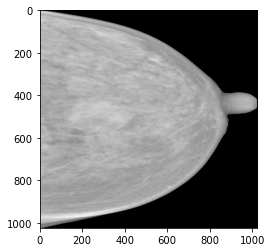

superposition of mask and bounding box:


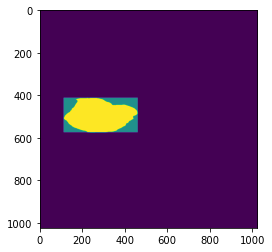

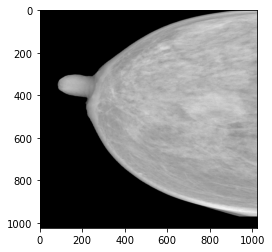

superposition of mask and bounding box:


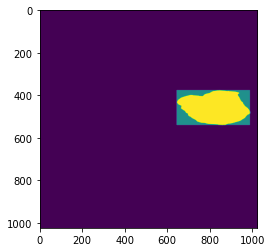

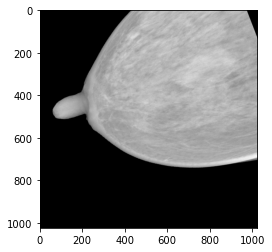

superposition of mask and bounding box:


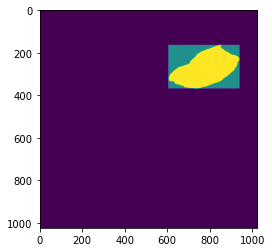

In [18]:
x,y=ImageLoader('22678646', resize=True)
x=[x]
y=[y]
x,y=Augment(x,y,3)
plot(x[0],y[0])
plot(x[1],y[1])
plot(x[2],y[2])

# Define dataset object

In [19]:
class INBreastDataset (Dataset):
    def __init__(self, mode, resize=True, size=(1024,1024),augmentation=True,n=8):
        #mode: train, validation or test
        #resize:resizes the image
        #size: new size, if resize==True
        #augmentation: allows data augmentation
        #n: number of times to augment each image
        
            
        #define class variables:
        self.images=[]
        self.masks=[]
        self.augment=augmentation
        self.n=n
            
        #obtain list of image indexes:
        if(mode=='train'):
            imageList=torch.load('trainSplit.pt')
        if(mode=='test'):
            imageList=torch.load('testSplit.pt')
        if(mode=='validation'):
            imageList=torch.load('validationSplit.pt')
            
        #load all images into RAM to avoid repeated disk access (about 10gb required):
        for name in imageList:
            x,y=ImageLoader(name,resize=resize,size=size)
            self.images.append(x)
            self.masks.append(y)
            
    def __len__(self):
        #returns dataset length
        
        return len(self.images)
    
    def __getitem__(self,idx):
        #returns image and target (bounding box)
        #If augmentation is used, returns a list of images 
        #and a list of corresponding bounding boxes,
        #created from a single original (non-augmented) image
        #idx: index to select image
        
        #Get single imagem and mask:
        img=self.images[idx]
        mask=self.masks[idx]
        x=[img]
        y=[mask]
        
        #Apply data augmentation:
        if(self.augment):
            x,y=Augment(x,y,self.n)
        
        #Generate bounding boxes:
        bb=[]
        for item in y:
            bb.append(bb_maker(item))
            
        #Convert image to torch, 3 channels and normalize:
        for i,_ in enumerate(x,0):
            x[i]=ToTorch(x[i])
        
        #create labels in the standard faster RCNN format:
        target=[]
        for i,_ in enumerate(bb,0):
            
            #bounding box to torch
            bb[i]=torch.tensor(bb[i])
            #number of masses:
            numBoxes=bb[i].shape[0]
            
            #dictionary target:
            labels={}
            #classes (always 1, mass, 0 is background):
            labels["labels"]=torch.ones(numBoxes).type(torch.int64)
            #image identifier:
            labels["image_id"]=torch.tensor([idx*self.n+i]).type(torch.int64)
            #iscrowd parameter, always 0 in this dataset:
            labels["iscrowd"]=torch.zeros(numBoxes).type(torch.uint8)
            #bounding boxes:
            labels["boxes"]=bb[i].float()
            #calculate areas of the bounding boxes:
            areas=[]
            for j in list(range(numBoxes)):
                areas.append((bb[i][j,2]-bb[i][j,0])*(bb[i][j,3]-bb[i][j,1]))
            #save areas to dictionary:
            labels["area"]=torch.tensor(areas)
            target.append(labels)
            
        
        return x,target


### Instantiate and check dataset object:

In [20]:
#instantiate:
Training=INBreastDataset('train')

In [21]:
#get an item:
Training.__getitem__(22)

([tensor([[[0.3384, 0.3355, 0.3258,  ..., 0.0000, 0.0000, 0.0000],
           [0.4152, 0.4138, 0.4105,  ..., 0.0000, 0.0000, 0.0000],
           [0.4481, 0.4520, 0.4462,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.4336, 0.4174, 0.4224,  ..., 0.0000, 0.0000, 0.0000],
           [0.4228, 0.4188, 0.4127,  ..., 0.0000, 0.0000, 0.0000],
           [0.4228, 0.4073, 0.4076,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.3384, 0.3355, 0.3258,  ..., 0.0000, 0.0000, 0.0000],
           [0.4152, 0.4138, 0.4105,  ..., 0.0000, 0.0000, 0.0000],
           [0.4481, 0.4520, 0.4462,  ..., 0.0000, 0.0000, 0.0000],
           ...,
           [0.4336, 0.4174, 0.4224,  ..., 0.0000, 0.0000, 0.0000],
           [0.4228, 0.4188, 0.4127,  ..., 0.0000, 0.0000, 0.0000],
           [0.4228, 0.4073, 0.4076,  ..., 0.0000, 0.0000, 0.0000]],
  
          [[0.3384, 0.3355, 0.3258,  ..., 0.0000, 0.0000, 0.0000],
           [0.4152, 0.4138, 0.4105,  ..., 0.0000, 0.0000, 0.0000],
           [0.4481, 0.

In [22]:
#check length:
Training.__len__()

74

In [23]:
#check image shape:
Training.__getitem__(22)[0][0].shape

torch.Size([3, 1024, 1024])

In [24]:
#check bounding box shape:
Training.__getitem__(22)[1][0]['boxes'].shape

torch.Size([1, 4])

# Define best anchor sizes

We need to analyze the masses size in the dataset to find the ideal anchor sizes. Consider 1024x1024 images. Anchors are defined by a list of sizes and a list of aspect ratios. Thus, we shall use K-means to first cluster the different bounding boxes sizes, afterwards we will use it again, inside each size cluster, to cluster the aspect ratios.

To ensure generalization, we will not use test data for clustering, as the process uses the labels in the dataset.

In [25]:
#create a list with all bounding boxes shapes (width,height)
#in the training and validation datasets:
masses=[]
i=0
for name in torch.load('trainSplit.pt')+torch.load('validationSplit.pt'):
    #load mask:
    _,y=ImageLoader(str(name),resize=True,size=(1024,1024))
    #create bounding boxes:
    bb=bb_maker(y)
    #save boxes width and height:
    for b in bb:
        masses.append([b[2]-b[0],b[3]-b[1]])#width,height


In [26]:
#check number of boxes:
len(masses)

92

In [27]:
#print shapes:
masses

[[348, 162],
 [351, 88],
 [154, 100],
 [232, 118],
 [96, 50],
 [156, 88],
 [78, 42],
 [80, 24],
 [60, 36],
 [92, 38],
 [160, 80],
 [88, 80],
 [146, 72],
 [156, 46],
 [72, 44],
 [154, 56],
 [310, 104],
 [304, 80],
 [416, 172],
 [388, 186],
 [200, 88],
 [182, 86],
 [372, 130],
 [214, 152],
 [284, 212],
 [254, 152],
 [384, 200],
 [344, 148],
 [670, 252],
 [120, 58],
 [172, 60],
 [180, 86],
 [196, 74],
 [244, 118],
 [290, 142],
 [126, 34],
 [120, 36],
 [326, 150],
 [350, 130],
 [292, 236],
 [228, 150],
 [354, 176],
 [466, 174],
 [120, 60],
 [462, 172],
 [398, 238],
 [424, 160],
 [4, 4],
 [132, 68],
 [110, 48],
 [60, 16],
 [70, 26],
 [170, 74],
 [206, 108],
 [140, 68],
 [150, 52],
 [367, 228],
 [388, 204],
 [298, 118],
 [268, 104],
 [186, 136],
 [186, 84],
 [150, 78],
 [130, 84],
 [118, 58],
 [88, 38],
 [454, 178],
 [146, 70],
 [342, 132],
 [116, 40],
 [102, 56],
 [52, 20],
 [118, 76],
 [260, 114],
 [278, 88],
 [132, 66],
 [134, 64],
 [172, 58],
 [222, 104],
 [168, 64],
 [154, 74],
 [258, 1

In [28]:
#create arrays of widths and heights:
widths=np.array(masses)[:,0]
heights=np.array(masses)[:,1]

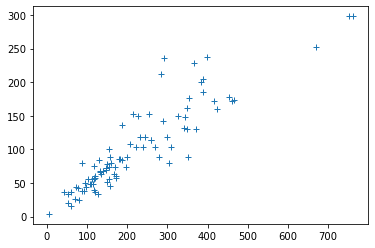

In [29]:
#plot widths Vs. heights:
plt.plot(widths,heights,'+')

### Use k-means to cluster the boxes' scales/sizes:

In [30]:
#calculate the size of each bounding box:
sizes=[]
for mass in masses:
    sizes.append((mass[0]*mass[1])**(1/2))

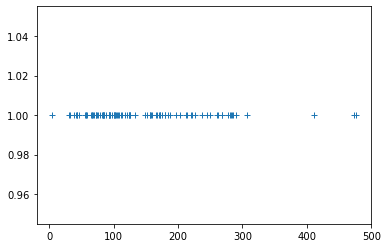

In [31]:
#Plot all boxes' sizes: 
plt.plot(sizes,widths/widths,'+')

In [32]:
#print sizes:
sizes

[237.43630724891256,
 175.7498221905217,
 124.09673645990857,
 165.45694303957148,
 69.2820323027551,
 117.16654812701448,
 57.23635208501674,
 43.81780460041329,
 46.475800154489,
 59.12698199637793,
 113.13708498984761,
 83.90470785361212,
 102.52804494381037,
 84.71127433818948,
 56.28498911788115,
 92.8654941299512,
 179.55500549970753,
 155.9487095169434,
 267.4920559568078,
 268.641024417344,
 132.664991614216,
 125.1079533842673,
 219.90907211845536,
 180.35520508152794,
 245.37318516904003,
 196.48918545304218,
 277.1281292110204,
 225.63687641872727,
 410.90144803833437,
 83.42661445845684,
 101.58740079360236,
 124.41864811996632,
 120.43255373859678,
 169.68205562168322,
 202.92855885754474,
 65.45227268781429,
 65.72670690061993,
 221.13344387495982,
 213.3072900770154,
 262.5109521524769,
 184.9324200890693,
 249.60769218916312,
 284.7525241327985,
 84.8528137423857,
 281.8935969475007,
 307.7726433586975,
 260.4611295375953,
 4.0,
 94.74175425861608,
 72.6636084983398,
 3

In [33]:
#to numpy and reshape:
sizes=np.array(sizes).reshape(-1, 1)

In [34]:
#apply K-means, with 5 clusters (number of scales in the FPN):
kmeans=sklearn.cluster.KMeans(n_clusters=5).fit(sizes)

In [35]:
#get centroids (will be used in the anchors):
centroids=kmeans.cluster_centers_

In [36]:
#print centroids:
centroids

array([[179.57272031],
       [101.82673722],
       [268.23922174],
       [453.60471966],
       [ 54.28830372]])

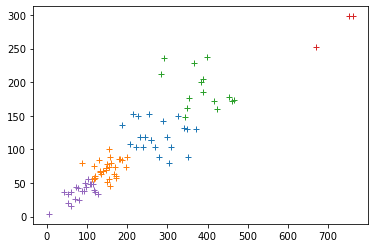

In [39]:
#plot clustered elements:
colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for cluster in list(range(5)):
    itens=[]
    for i,item in enumerate(masses,0):
            if(kmeans.labels_[i]==cluster):
                itens.append(masses[i])
    widths=np.array(itens)[:,0]
    heights=np.array(itens)[:,1]
    plt.plot(widths,heights,'+',color=colors[cluster])
plt.show()

### Use K-means to cluster the aspect ratios

For each size cluster we will cluster the itens aspect ratios:

Cluster  [179.57272031]  ratios:
[[0.33964328]
 [0.67444578]
 [0.47204453]]
Cluster  [101.82673722]  ratios:
[[0.34996068]
 [0.48711749]
 [0.7121658 ]]
Cluster  [268.23922174]  ratios:
[[0.54040108]
 [0.77734903]
 [0.40347503]]
Cluster  [453.60471966]  ratios:
[[0.39107612]
 [0.3761194 ]
 [0.3962766 ]]
Cluster  [54.28830372]  ratios:
[[0.3717755 ]
 [0.92857143]
 [0.57887862]]


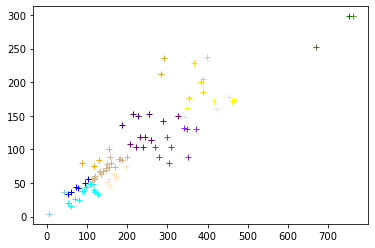

In [53]:
colors=['blueviolet','indigo','purple','bisque','tan','orange','gold','goldenrod','yellow',
       'olivedrab','darkolivegreen','green','cyan','skyblue','blue']
#Iterate over the 5 size clusters:
count=0
for cluster in list(range(5)):
    #get all aspect reatios in the cluster:
    ratios=[]
    itens=[]
    for i,item in enumerate(masses,0):
        if(kmeans.labels_[i]==cluster):
            ratios.append(masses[i][1]/masses[i][0])
            itens.append(masses[i])
    ratios=np.array(ratios).reshape(-1, 1)
    #apply k-mins to generate 3 aspect ratio clusters:
    kmeansRatios=sklearn.cluster.KMeans(n_clusters=3).fit(ratios)
    #plot clustered elements:
    for c in list(range(3)):
        tmp=[]
        for i,item in enumerate(itens,0):
            if (kmeansRatios.labels_[i]==c):
                tmp.append(itens[i])
        widths=np.array(tmp)[:,0]
        heights=np.array(tmp)[:,1]
        plt.plot(widths,heights,'+',color=colors[count])
        count=count+1
    #print centroids (of aspect ratio clusters) for each size cluster:
    print('Cluster ',centroids[cluster],' ratios:')
    print(kmeansRatios.cluster_centers_)
plt.show()        

# Faster R-CNN model definition

In [38]:
#download MS COCO pretrained faster R-CNN, based on resnet50:
net=torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
#Change output layer of fast R-CNN for 2 classes (mass and background):
net.roi_heads.box_predictor = FastRCNNPredictor(net.roi_heads.box_predictor.cls_score.in_features, 2)

### Define anchor bounding boxes

In [39]:
#Change anchor generator according to the sizes and 
#aspect ratio that we obtained with K-means and printed above
#obs: values change slightly every time K-means is run.
#The values used below are from the first run of K-means.

anchor_sizes = ((54,), (102,), (182,), (271,), (454,))
aspect_ratios = ((0.37,0.58,0.93,),
                 (0.35,0.49,0.71,),
                 (0.34,0.47,0.67,),
                 (0.39,0.53,0.78,),
                 (0.35,0.39,0.70,))
#the last cluster is too small, and all itens have almost the same aspect ratio,
#thus we added the values of 0.35 and 0.70, which are similar to the other clusters
net.rpn.anchor_generator=AnchorGenerator(anchor_sizes,aspect_ratios)

In [40]:
#transfer DNN to GPU
net.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

# Train

In [42]:
#instantiate datsets
Training=INBreastDataset('train',augmentation=True)
Validating=INBreastDataset('validation',augmentation=True)
Testing=INBreastDataset('test',augmentation=False)

#create dataloaders
trainingLoader=torch.utils.data.DataLoader(Training,batch_size=1,shuffle=True,num_workers=0)
validatingLoader=torch.utils.data.DataLoader(Validating,batch_size=1,shuffle=True,num_workers=0)
testingLoader=torch.utils.data.DataLoader(Testing,batch_size=1,shuffle=True,num_workers=0)

In [42]:
def Train(epochs,TLoader,VLoader,ES,LR,name,WD,schedule=False,factor=0.1,local=TrainedPath):
    #Training loop function. Iterates over the dataset perfoming training and 
    #hold-out validation.
    #Returns best DNN (according to validation loss), all training losses and
    #all validation losses.
    #epochs: maximum number of epochs
    #TLoader: training loader
    #VLoader: validation loader
    #ES: early stopping patience
    #LR: learning rate
    #name: DNN name (for saving)
    #WD: L2 regularization parameter
    #schedule: allows learning rate scheduler
    #factor: how much to decrease learning rate
    #local: where to save the DNN
    
    #get DNN as global variable:
    global net
    
    #define optimizer (SGD with momentum):
    optimizer = torch.optim.SGD(
        filter(
            lambda p: p.requires_grad,
            net.parameters()),
        lr=LR,
        momentum=0.9,
        weight_decay=WD)

    #list of training losses:
    history=[]
    #list of validation losses:
    validationHistory=[]
    BestLoss=100
    ESCount=0
    
    #define learning rate scheduler (reduce lr by a factor of 10 every 10 epochs):
    if(schedule):
        scheduler= torch.optim.lr_scheduler.StepLR(optimizer,
                                                   step_size=10,
                                                   gamma=factor)
    #iterate over training epochs:
    for epoch in range(epochs):
        
        #start timer:
        start=time.time()
        
        #training mode:
        net.train()
        
        #zero losses and auxiliart variables:
        running_loss = 0.0
        Valrunning_loss = 0.0
        count=0
        Valcount=0
        
        #iterate over training loader:
        for batch in TLoader:
            #get images and labels:
            images, targets = batch
            #we feed the DNN 1 image at a time, the batch produces 8
            #iterate over the 8 augmented images:
            for index in list(range(len(images))):
                #adapt data format for the DNN:
                inputs=images[index].squeeze(0).to(device)
                labels=targets[index]
                labels["labels"]=labels["labels"].squeeze(0).to(device)
                labels["image_id"]=labels["image_id"].squeeze(0).to(device)
                labels["iscrowd"]=labels["iscrowd"].squeeze(0).to(device)
                labels["boxes"]=labels["boxes"].squeeze(0).to(device)
                labels["area"]=labels["area"].squeeze(0).to(device)
                labels=[labels]
                inputs=[inputs]
                
                #clean memory:
                batch=0 

                #forward pass:
                with torch.cuda.amp.autocast(enabled=use_amp):
                    out=net(inputs,labels)
                    #loss calculation:
                    loss=sum(loss for loss in out.values())

                #backpropagation:
                scaler.scale(loss).backward()
                
                #parameter optimization:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
                
                #save loss:
                running_loss += loss.item()
                count=count+1
    
      
        #clean memory:
        inputs=0
        labels=0

        #network validation:
        with torch.no_grad():
            #iterate over validation dataset:
            for batch in VLoader:
                #get images and labels:
                images, targets = batch
                #we feed the DNN 1 image at a time, the batch produces 8
                #iterate over the 8 augmented images:
                for index in list(range(len(images))):
                    #adapt data format for the DNN:
                    inputs=images[index].squeeze(0).to(device)
                    labels=targets[index]
                    labels["labels"]=labels["labels"].squeeze(0).to(device)
                    labels["image_id"]=labels["image_id"].squeeze(0).to(device)
                    labels["iscrowd"]=labels["iscrowd"].squeeze(0).to(device)
                    labels["boxes"]=labels["boxes"].squeeze(0).to(device)
                    labels["area"]=labels["area"].squeeze(0).to(device)
                    labels=[labels]
                    inputs=[inputs]

                    #clean memory:
                    batch=0 
                    
                    #forward pass:
                    with torch.cuda.amp.autocast(enabled=use_amp):
                        out=net(inputs,labels)
                        #Calculate only Fast R-CNN loss:
                        Valloss=out['loss_classifier']+out['loss_box_reg']
                    
                    #save validation loss:
                    Valrunning_loss += Valloss.item()
                    Valcount=Valcount+1
 
        #clean memory:
        inputs=0
        labels=0
        
        #calculate mean epoch losses:
        EpochLoss = running_loss/count
        EpochValLoss=Valrunning_loss/Valcount
        
        #update learning rate:
        if(schedule):
            scheduler.step(EpochValLoss)
            
        #evaluate if this DNN has the best validation loss:
        ESCount=ESCount+1
        if (EpochValLoss<BestLoss):
                    BestLoss=EpochValLoss
                    BestNet=copy.deepcopy(net)
                    ESCount=0
                    #save best DNN:
                    torch.save(BestNet,local+name+'BestCheck.pt')
        
        #save losses to history lists (for plotting):
        history.append(EpochLoss)
        validationHistory.append(EpochValLoss)
        end=time.time()
        
        #print epoch statistics:
        print('epoch:',len(history),',loss:',EpochLoss,',time:',(end-start), ',Val Loss:',EpochValLoss, 'ES', ESCount)
        
        
        #checkpoint: save DNN and state
        torch.save(net,local+name+'check.pt')
        if(schedule):
            torch.save([optimizer.state_dict(),BestLoss,ESCount,scheduler.state_dict(),scaler.state_dict()],local+name+'info.pt')
        else:
            torch.save([optimizer.state_dict(),BestLoss,ESCount,scaler.state_dict()],local+name+'info.pt')
        torch.save((history,validationHistory),local+name+'his.pt')
        
        
        #evaluate early stopping:
        if (ESCount>=ES):
            print('Early Stop')
            return (BestNet,history,validationHistory)

    print('Finished Training')
    torch.save(net,local+name+'FT.pt')
    return (BestNet,history,validationHistory)

In [43]:
#run training loop
best,Hist,valHist=Train(200,trainingLoader,validatingLoader,ES=30, LR=1e-4,name=NetName,WD=0.001,schedule=True)

/home/pedro/anaconda3/envs/mestardoBackup/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


epoch: 1 ,loss: 0.37664988074401345 ,time: 81.46490907669067 ,Val Loss: 0.22383122981991618 ES 0
epoch: 2 ,loss: 0.26234753792350357 ,time: 81.2821261882782 ,Val Loss: 0.25822081631049515 ES 1
epoch: 3 ,loss: 0.21122801660031482 ,time: 81.68497610092163 ,Val Loss: 0.2258168138563633 ES 2
epoch: 4 ,loss: 0.17783939222352127 ,time: 81.05000591278076 ,Val Loss: 0.22590139601379633 ES 3
epoch: 5 ,loss: 0.16074673689247385 ,time: 81.34394383430481 ,Val Loss: 0.23378868845757098 ES 4
epoch: 6 ,loss: 0.15440155307737155 ,time: 79.03843402862549 ,Val Loss: 0.22594471285119652 ES 5
epoch: 7 ,loss: 0.1451650472810945 ,time: 79.65295624732971 ,Val Loss: 0.23660595985129476 ES 6
epoch: 8 ,loss: 0.13884443544619088 ,time: 79.57509851455688 ,Val Loss: 0.22180601293221117 ES 0
epoch: 9 ,loss: 0.12757726350950227 ,time: 79.55667972564697 ,Val Loss: 0.2652827205136418 ES 1
epoch: 10 ,loss: 0.11865741475107702 ,time: 78.93362617492676 ,Val Loss: 0.2422011015471071 ES 2
epoch: 11 ,loss: 0.114238087506335

In [44]:
def plotData(history):
    #plot loss
    #history: list of losses during training
    epochs=range(len(history))
    plt.plot(epochs,history,label='Training Loss')

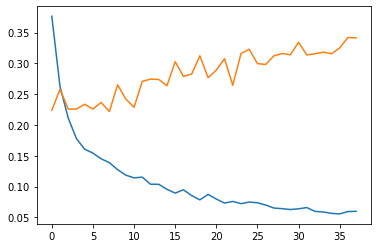

In [45]:
#plot training loss (blue) and validation loss (orange):
plotData(Hist)
plotData(valHist)

# Testing functions

In [45]:
def mAP(Loader,dnn,NMS=False,th=0.5,returnConfidence=False,minimum=0):
    #Writes predicions and ground thruth to txt files,
    #to be analyzed with mean average precision (mAP)
    #with the program available at:https://github.com/Cartucho/mAP
    #loader: data loader
    #dnn: neural network
    #NMS: allows non-maximum suppression
    #th: threshold for NMS
    #returnConfidence: allows returning class confidences
    #minimum: class confidence threshold to accept predictions
    
    #define folders to save predictions, images and labels:
    predLocation='/home/pedro/mAP/input/detection-results/'
    labelLocation='/home/pedro/mAP/input/ground-truth/'
    imagesLocation='/home/pedro/mAP/input/images-optional/'
    
    #evaluation mode:
    dnn.eval()
    imgIdx=0
    confidences=[]
    
    #iterate over test dataset:
    with torch.no_grad():
        for batch in Loader:
            images, targets = batch
            for index in list(range(len(images))):
                imgIdx=imgIdx+1
                
                #auxiliary lists to collect predictions and labels:
                allPredictions=[]
                allLabels=[]
                
                #adapt data format for the DNN:
                inputs=images[index].squeeze(0).to(device)
                labels=targets[index]
                labels["labels"]=labels["labels"].squeeze(0).to(device)
                labels["image_id"]=labels["image_id"].squeeze(0).to(device)
                labels["iscrowd"]=labels["iscrowd"].squeeze(0).to(device)
                labels["boxes"]=labels["boxes"].squeeze(0).to(device)
                labels["area"]=labels["area"].squeeze(0).to(device)
                labels=[labels]
                inputs=[inputs]
                
                #forward propagation:
                predictions=dnn(inputs)
                               
                #non-maximum suppression:
                if (NMS):
                    keep=torchvision.ops.batched_nms(predictions[0]['boxes'],
                                                     predictions[0]['scores'],
                                                     predictions[0]['labels'],
                                                     th)
                    predictions[0]['scores']=predictions[0]['scores'][keep]
                    predictions[0]['boxes']=predictions[0]['boxes'][keep]
                
                #change format for labels and outputs, creating strings:
                #Format for labels: <mass> <x0> <y0> <x1> <y1>
                #Format for predictions: <mass> <confidence> <x0> <y0> <x1> <y1>
                for box in labels[0]['boxes']:
                    string='mass'
                    for j in list(range(4)):
                        string=string+' '+str(int(box[j].item()))
                    allLabels.append(string)
                    
                for i,box in enumerate(predictions[0]['boxes'],0):
                    string='mass'
                    string=string+' '+str(round(predictions[0]['scores'][i].item(),6))
                    confidences.append(round(predictions[0]['scores'][i].item(),6))
                    for j in list(range(4)):
                        string=string+' '+str(int(box[j].item()))
                    if(predictions[0]['scores'][i].item()>minimum):
                        allPredictions.append(string)  
                
                #write strings to txt files:
                with open(predLocation+str(imgIdx)+'.txt', 'w') as f:
                    for item in allPredictions:
                        f.write("%s\n" % item)
                with open(labelLocation+str(imgIdx)+'.txt', 'w') as f:
                    for item in allLabels:
                        f.write("%s\n" % item)
                
                #save test image:
                inputs=inputs[0][0]*255
                pil=Image.fromarray(inputs.cpu().numpy()).convert('RGB')
                pil.save(imagesLocation+str(imgIdx)+'.jpg')
                
    if(returnConfidence):
        return confidences


In [51]:
#create txt bounding boxes to be evaluated with mAP, using test dataset
best=torch.load(TrainedPath+NetName+'BestCheck.pt',map_location=device)
mAP(testingLoader,dnn=best)

82.7% mean average precision.

Calculated with the program in https://github.com/Cartucho/mAP.

# Print test dataset analyzed by the Faster R-CNN, using class confidence threshold of 0.4

Blue: ground-thruth, correctly detected

Pink: ground-thruth, not/incorrectly detected

Green: correct prediction

Red: wrong prediction (insuficient IoU with a ground thruth or duplicated detection)

In [63]:
#create txt bounding boxes to be evaluated with mAP, using test dataset
best=torch.load(TrainedPath+NetName+'BestCheck.pt',map_location=device)
confidence=mAP(testingLoader,dnn=best,returnConfidence=True,minimum=0.4)

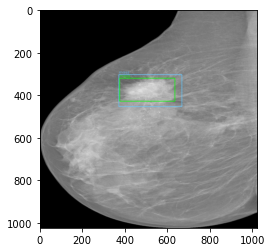

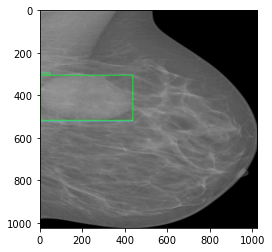

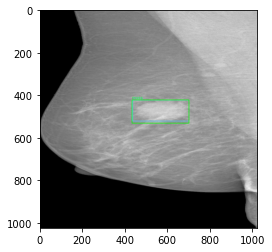

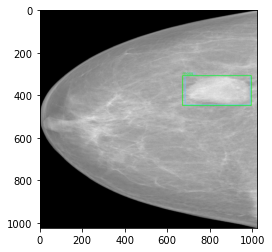

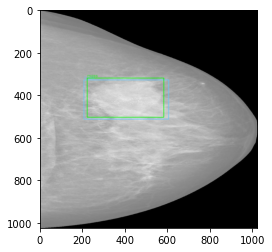

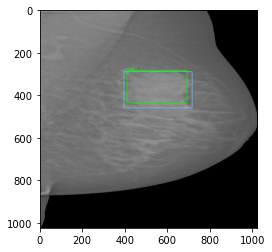

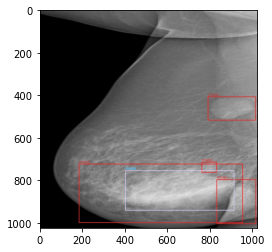

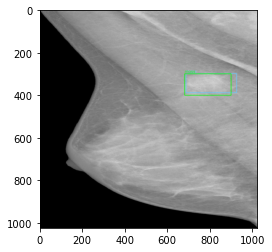

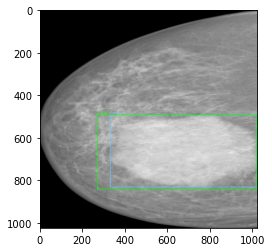

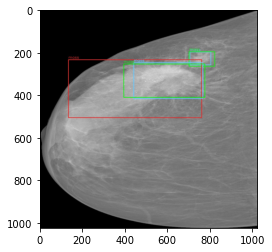

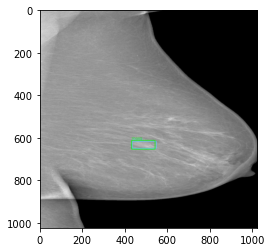

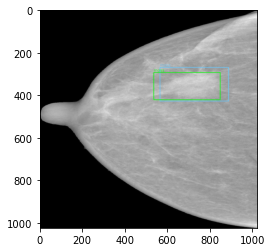

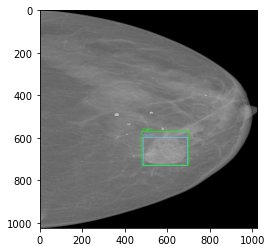

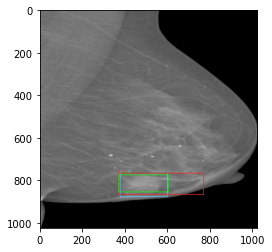

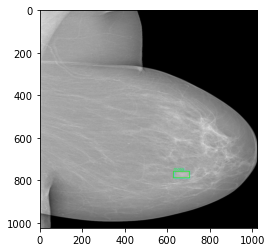

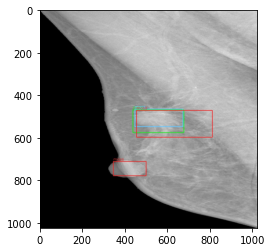

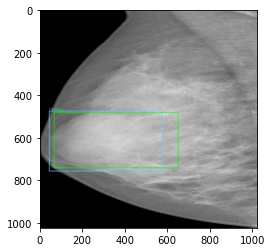

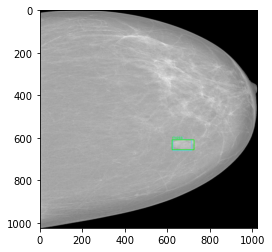

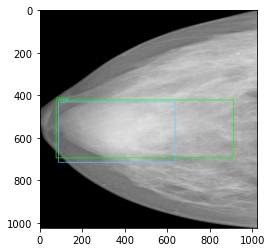

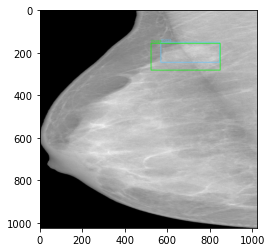

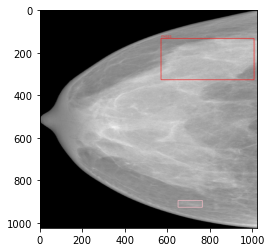

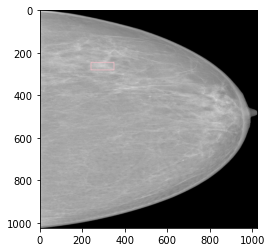

In [58]:
#print images:
location='/home/pedro/mAP/output/images/'
for name in os.listdir(location):
    if ('jpg' in name):
        img=plt.imread(location+name)
        plt.imshow(img)
        plt.show()

# What happens in healthy mammograms?

Let's use or model with healthy mammograms, to understand the percentage of images that have false positives.

### Select normal images

In [64]:
#read dataset information file:
itens=pandas.read_excel(root+'INbreast.xls')

In [74]:
#Select images classified as "Normal":
imagesNormal=[]
for i,item in enumerate(itens['Mass'],0):
    if (itens['Mass'][i] != 'X' and itens['Mass'][i] != 'X' and itens['Micros'][i] != 'X' and itens['Distortion'][i] != 'X' and itens['Asymmetry'][i] != 'X'):
        if (itens['File Name'][i].is_integer()):
            imagesNormal.append(str(int(itens['File Name'][i])))

In [75]:
#total number of normal images:
len(imagesNormal)

68

In [77]:
#save list:
torch.save(imagesNormal,'normalImages.pt')

In [97]:
#change image loader to return only the image (normal images have no mask):
def NormalLoader (name,resize=False,size=(1024,1024)):
    #returns the image (numpy array)
    #resize:resizes the image
    #size: new size, if resize=True
    #name: image index
    
    #gets the complete filename for the image:
    for item in os.listdir(root+'AllDICOMs/'):
        if(name in item):
            imgFile=item
            break 
    
    #load image:
    image=pydicom.dcmread(root+'AllDICOMs/'+imgFile).pixel_array
    
    #crop borders:
    image,_=crop(image,image)
    
    #resize (nearest neighbor interpolation):
    if(resize):
        image=cv2.resize(image, dsize=size, interpolation=cv2.INTER_NEAREST)
    
    return image

#change the dataset class to load normal images and empty bounding boxes:
class NormalINBreastDataset (Dataset):
    def __init__(self, resize=True, size=(1024,1024)):
        #resize:resizes the image
        #size: new size, if resize==True        
            
        #define class variables:
        self.images=[]

        #obtain list of image indexes:
        imageList=torch.load('normalImages.pt')
            
        #load all images into RAM to avoid repeated disk access:
        for name in imageList:
            x=NormalLoader(name,resize=resize,size=size)
            self.images.append(x)
            
    def __len__(self):
        #returns dataset length
        
        return len(self.images)
    
    def __getitem__(self,idx):
        #returns image and empty boundiong box (0 size)
        #idx: index to select image
        
        #Get single imagem:
        img=self.images[idx]
        x=[img]
        target=[]
        
        #Convert image to torch, 3 channels and normalize:
        for i,_ in enumerate(x,0):
            x[i]=ToTorch(x[i])
         
        #generate labels of zeros:
        numBoxes=1
        #dictionary target:
        labels={}
        #classes:
        labels["labels"]=torch.ones(numBoxes).type(torch.int64)
        #image identifier:
        labels["image_id"]=torch.tensor([idx]).type(torch.int64)
        #iscrowd parameter, always 0 in this dataset:
        labels["iscrowd"]=torch.zeros(numBoxes).type(torch.uint8)
        #bounding boxes (empty for normal images):
        labels["boxes"]=torch.tensor([[0,0,0,0]]).float()
        #save areas to dictionary (zero for normal images):
        labels["area"]=torch.tensor([0])
        target.append(labels)
            
        
        return x,target

#instantiate datset:
Normal=NormalINBreastDataset()
#create dataloader:
normalLoader=torch.utils.data.DataLoader(Normal,batch_size=1,shuffle=True,num_workers=0)

In [110]:
#solve dataset and save solutions as txt:
mAP(normalLoader,dnn=best,minimum=0.5)

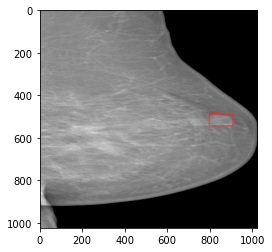

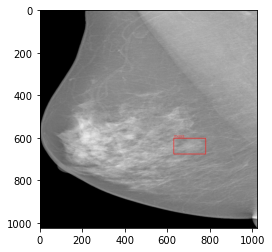

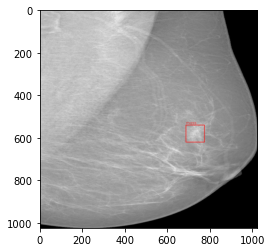

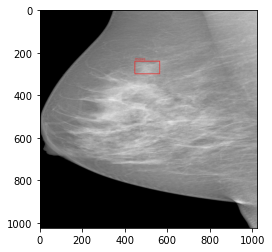

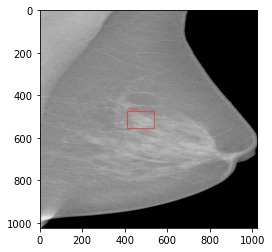

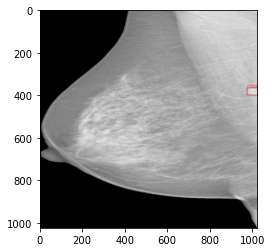

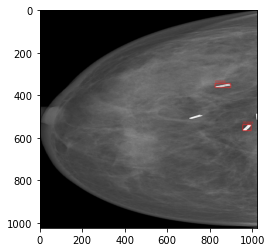

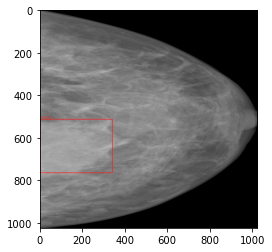

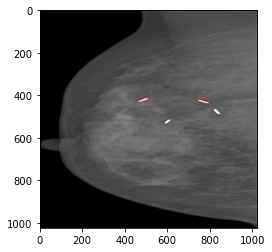

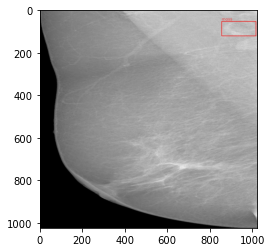

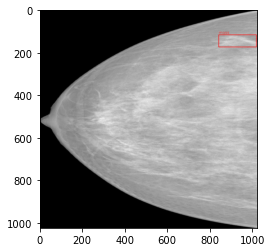

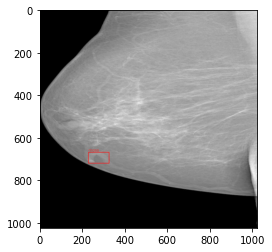

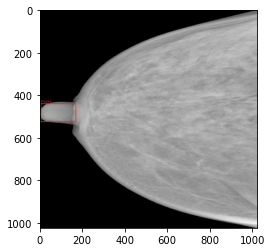

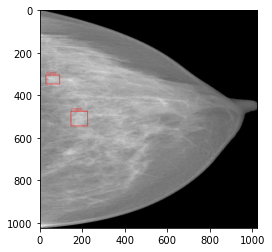

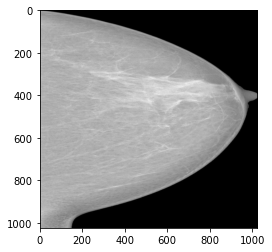

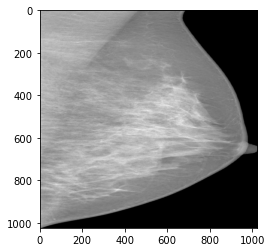

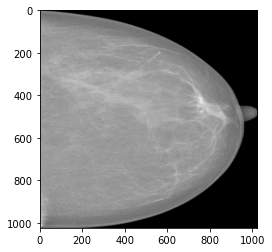

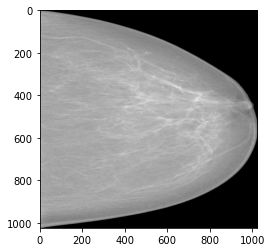

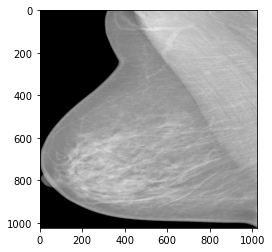

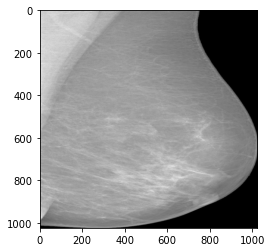

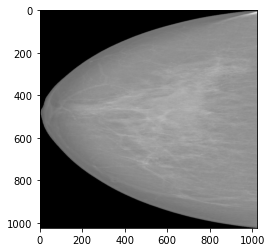

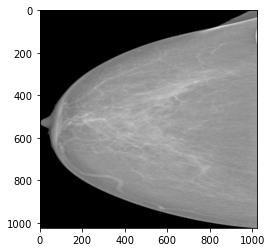

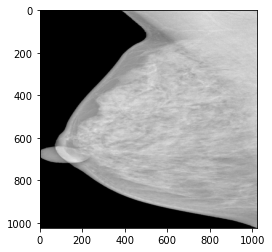

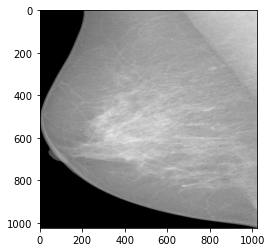

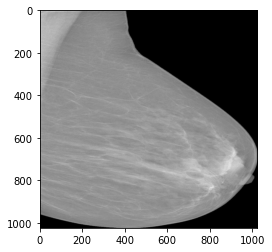

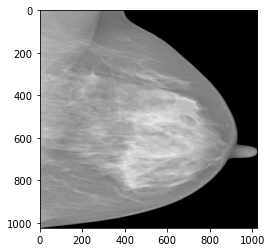

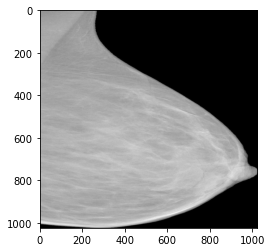

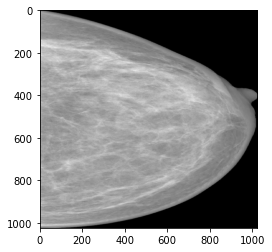

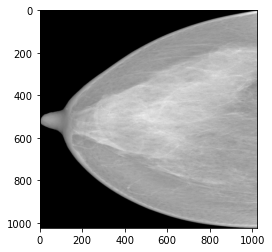

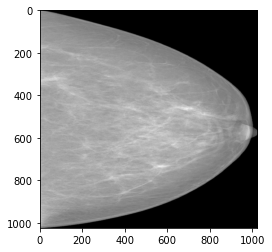

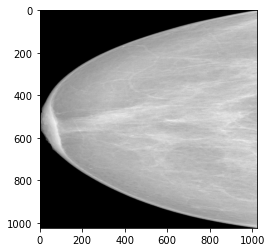

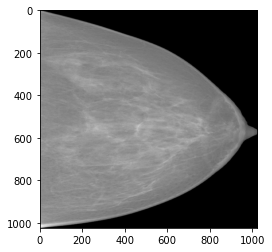

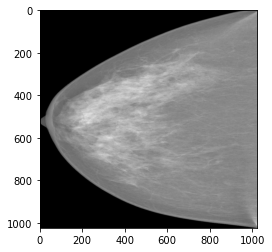

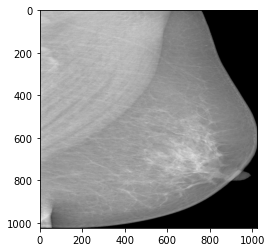

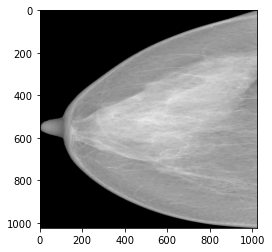

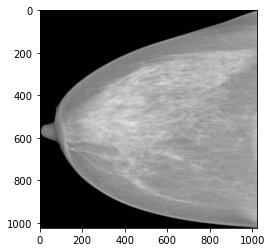

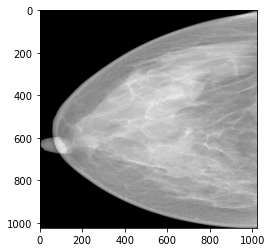

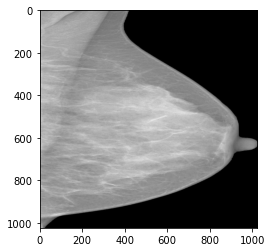

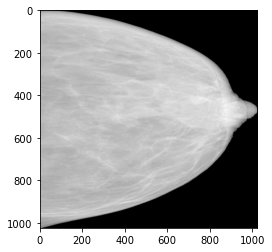

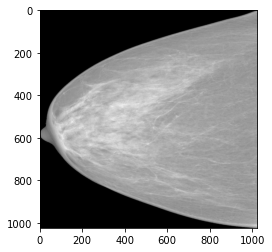

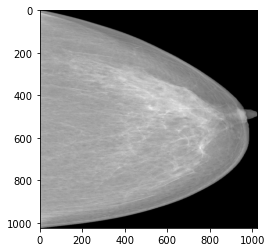

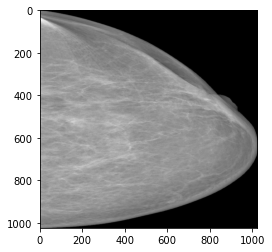

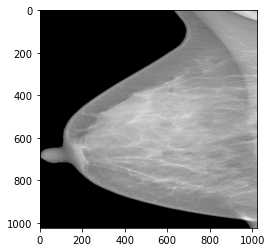

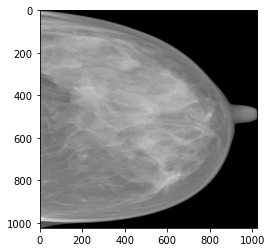

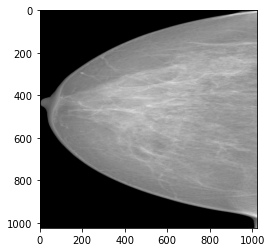

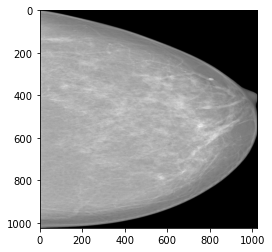

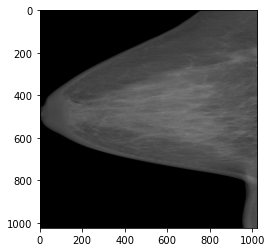

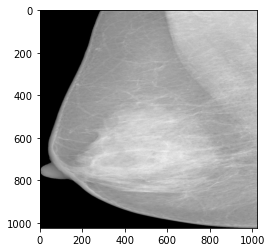

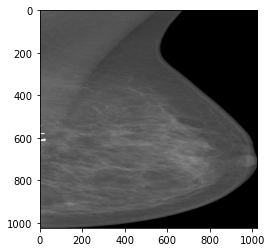

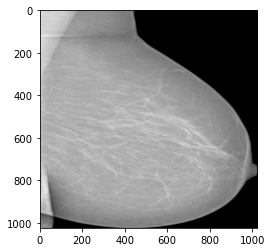

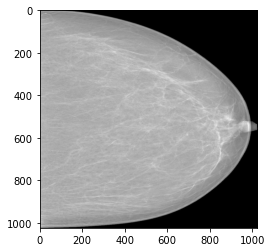

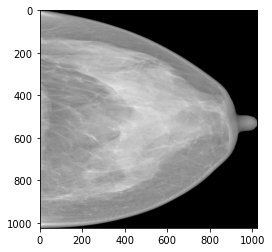

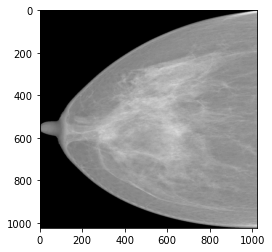

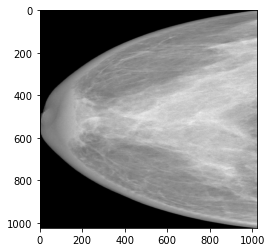

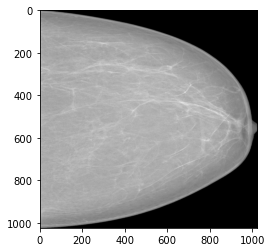

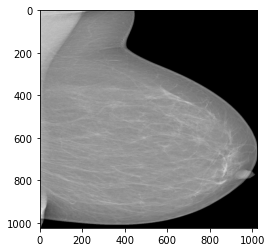

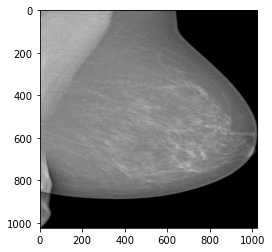

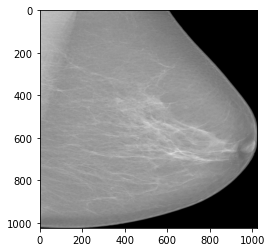

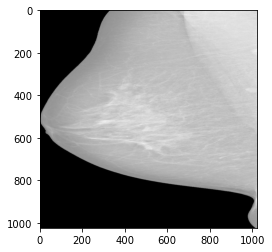

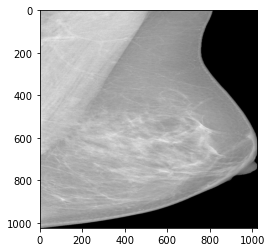

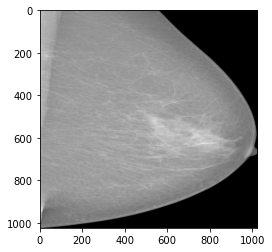

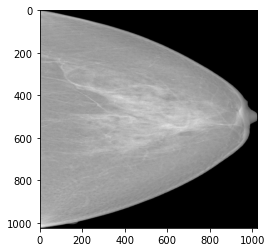

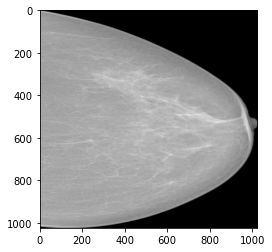

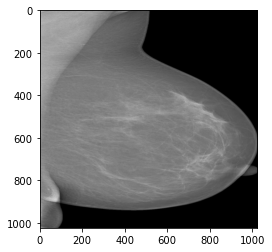

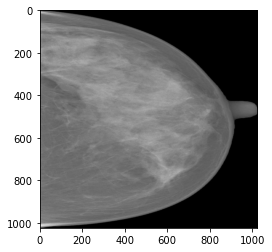

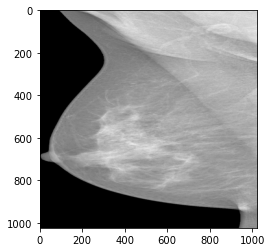

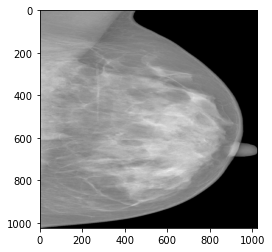

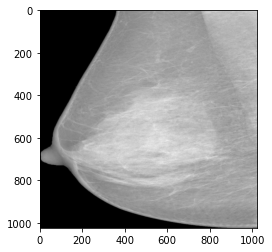

In [111]:
#print images with detections: 
#created using the program at https://github.com/Cartucho/mAP
location='/home/pedro/mAP/output/images/'
for name in os.listdir(location):
    if ('jpg' in name):
        img=plt.imread(location+name)
        plt.imshow(img)
        plt.show()